# PiML Toolbox: High-code Demo for CaliforniaHousing Data

This example notebook demonstrates how to use PiML with its high-code APIs for developing machine learning models for the CaliforniaHousing data, which consists of 20,640 samples and 9 features, fetched by sklearn.datasets (see details here). PiML can load three versions of this data, including _raw, _trim1 (trimming only AveOccup) and _trim2 (trimming AveRooms, AveBedrms, Population and AveOccup). The _trim2 version is used in this example.

The response MedHouseVal (median house price per block in log scale) is continuous and it is a regression problem.

# Stage 0: Install PiML package on Google Colab

1. Run `!pip install piml` to install the latest version of PiML. It requires V0.2 or above to use high-code APIs.
2. In Colab, you'll need restart the runtime in order to use newly installed PiML version.

In [ ]:
!pip install piml

# Stage 1: Initialize an experiment, Load and Prepare data

In [ ]:
from piml import Experiment
exp = Experiment()

In [ ]:
exp.data_loader(data='CaliforniaHousing_trim2')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [ ]:
exp.data_summary(feature_exclude=[])

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='Data Shape:(20640, 9)')

In [ ]:
exp.data_prepare(target='MedHouseVal', task_type='Regression', test_ratio=0.2, random_state=0)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Output()

,0,1
0,Inactive columns name,[]
1,Target colunm name,MedHouseVal
2,Task type,Regression
3,Test ratio,0.2
4,Random state,0


In [ ]:
exp.eda(show='all', uni_feature='MedHouseVal', bi_features=['Longitude', 'Latitude'], 
        multi_type='correlation_heatmap')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

# Stage 2. Train intepretable models  

In [ ]:
## ReLU-DNN: ReLU Deep Neural Networks with L1-Regularization
from piml.models import ReluDNNRegressor

clf1 = ReluDNNRegressor(hidden_layer_sizes=(40, 40), l1_reg=1e-05,
                        batch_size=500, learning_rate=0.001)
exp.model_train(model=clf1, name='ReLU-DNN')
exp.model_diagnose(model="ReLU-DNN", show='accuracy_result')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value="<p class='notification info'>Register ReLU-DNN Done</p>")

,,MSE,MAE,R2
0,Train,0.011659,0.073708,0.795091
1,Test,0.012315,0.076122,0.777847
2,Gap,0.000656,0.002414,-0.017244


In [ ]:
## GAMI-Net: GAM-Neural Networks with Structured Interactions
from piml.models import GAMINetRegressor

clf2 = GAMINetRegressor(interact_num=10, loss_threshold=0.01,  
                        subnet_size_main_effect=[20], 
                        subnet_size_interaction=[20,20])
exp.model_train(model=clf2, name='GAMI-Net')
exp.model_diagnose(model="GAMI-Net", show='accuracy_result')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value="<p class='notification info'>Register GAMI-Net Done</p>")

,,MSE,MAE,R2
0,Train,0.011585,0.074184,0.796387
1,Test,0.012394,0.076799,0.776413
2,Gap,0.000809,0.002615,-0.019975


In [ ]:
## EBM: Explainable Boosting Machine from MS Research
from piml.models import ExplainableBoostingRegressor

clf3 = ExplainableBoostingRegressor(interactions=10, random_state=0)
exp.model_train(model=clf3, name='EBM')
exp.model_diagnose(model="EBM", show='accuracy_result')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value="<p class='notification info'>Register EBM Done</p>")

,,MSE,MAE,R2
0,Train,0.010811,0.072170,0.809985
1,Test,0.011603,0.074227,0.790682
2,Gap,0.000792,0.002058,-0.019303


In [ ]:
exp.model_compare(models=['ReLU-DNN', 'GAMI-Net', 'EBM'], show='accuracy')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

# Stage 3. Explain and Interpret

## Post-hoc Explaination: Global and Local Methods 

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

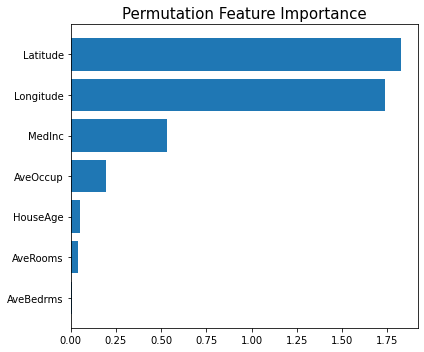

In [ ]:
exp.model_explain(model='GAMI-Net', show='global_pfi', figsize=(6,5))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

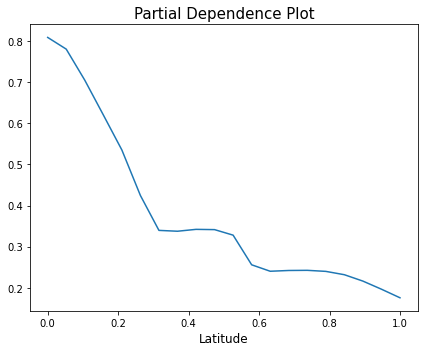

In [ ]:
exp.model_explain(model='GAMI-Net', show='global_pdp', uni_feature='Latitude', figsize=(6,5))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

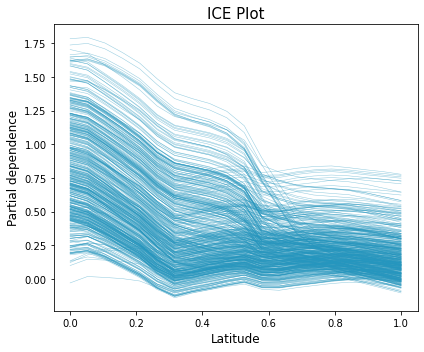

In [ ]:
exp.model_explain(model='GAMI-Net', show='global_ice', uni_feature='Latitude', figsize=(6,5))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

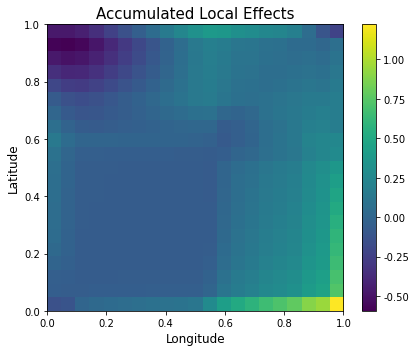

In [ ]:
exp.model_explain(model='GAMI-Net', show='global_ale', bi_features=['Longitude', 'Latitude'], figsize=(6,5))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

  0%|          | 0/50 [00:00<?, ?it/s]

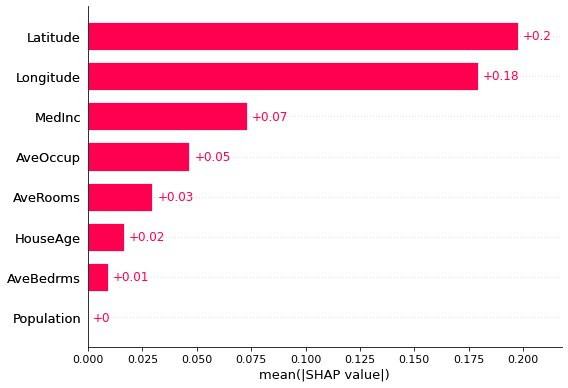

In [ ]:
exp.model_explain(model='GAMI-Net', show='global_shap_fi', sample_size=50)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

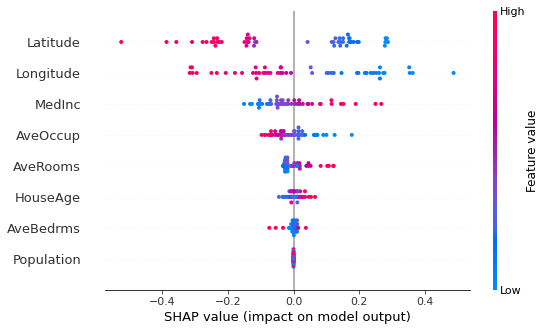

In [ ]:
exp.model_explain(model='GAMI-Net', show='global_shap_summary', 
                  sample_size=50)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

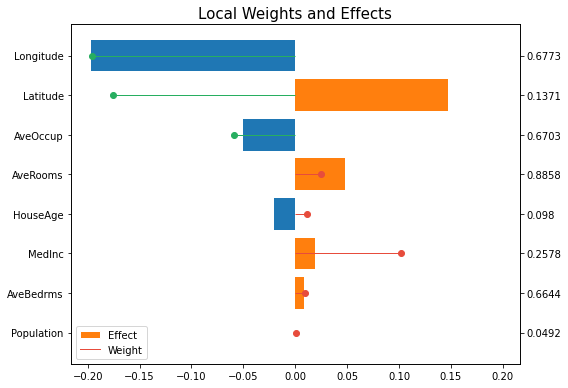

In [ ]:
exp.model_explain(model='GAMI-Net', show='local_lime', sample_id=0)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

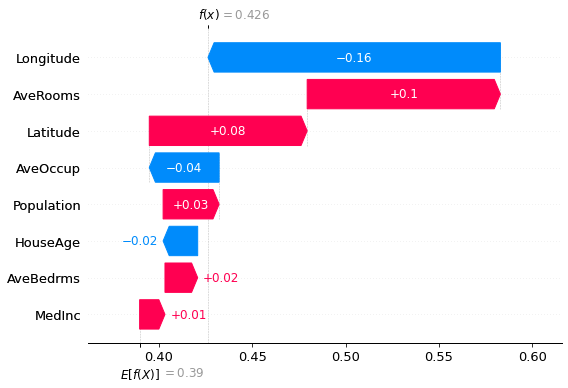

In [ ]:
exp.model_explain(model='EBM', show='local_shap', sample_id=0)

## Inherent Interpretation: Global and Local Methods

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

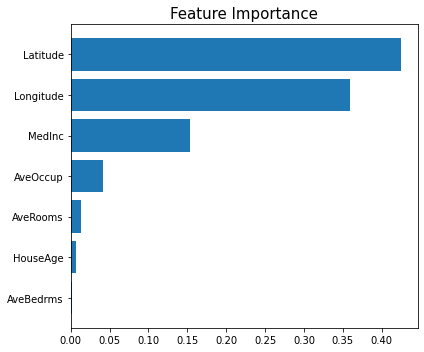

In [ ]:
exp.model_interpret(model='GAMI-Net', show='global_fi', figsize=(6,5))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

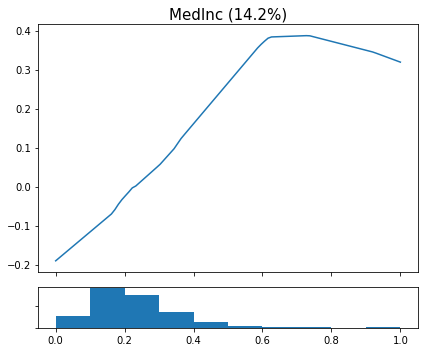

In [ ]:
exp.model_interpret(model='GAMI-Net', show='global_effect_plot', uni_feature='MedInc', figsize=(6,5))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

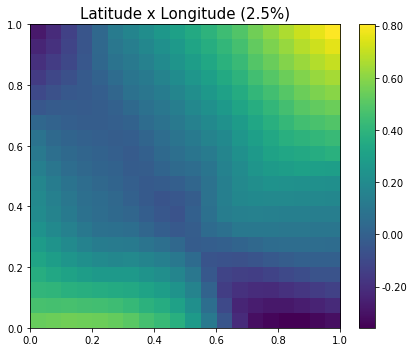

In [ ]:
exp.model_interpret(model='GAMI-Net', show='global_effect_plot', 
                    bi_features=['Longitude', 'Latitude'], figsize=(6,5))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

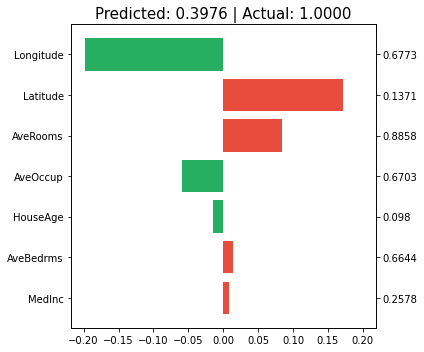

In [ ]:
exp.model_interpret(model='GAMI-Net', show='local_fi', sample_id=0, figsize=(6,5))

# Stage 4. Diagnose and Compare

In [ ]:
exp.model_diagnose(model='GAMI-Net', show='accuracy_result')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,,MSE,MAE,R2
0,Train,0.011585,0.074184,0.796387
1,Test,0.012394,0.076799,0.776413
2,Gap,0.000809,0.002615,-0.019975


HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

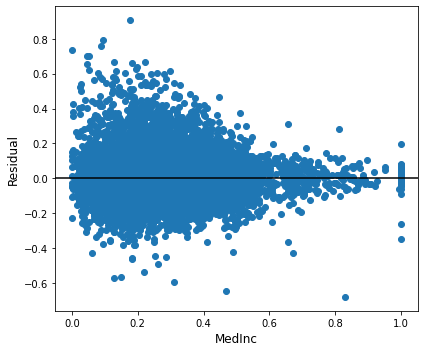

In [ ]:
exp.model_diagnose(model='GAMI-Net', show='accuracy_residual', target_feature='MedInc', figsize=(6, 5))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

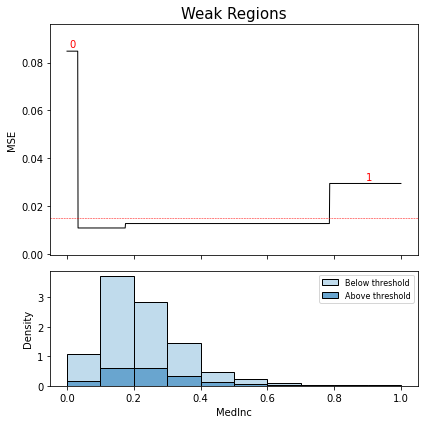

In [ ]:
exp.model_diagnose(model='GAMI-Net', show='weakspot_plot', slice_features=['MedInc'], 
                   slice_method='tree', threshold=1.2, min_sample=20, figsize=(6, 6))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

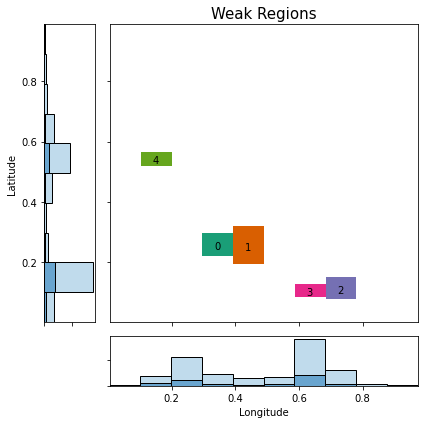

In [ ]:
exp.model_diagnose(model='GAMI-Net', show='weakspot_plot', slice_features=['Longitude', 'Latitude'], 
                   slice_method='histogram', threshold=1.2, min_sample=20, figsize=(6, 6))

In [ ]:
exp.model_diagnose(model='GAMI-Net', show='weakspot_result', slice_features=['Longitude', 'Latitude'], 
                   slice_method='histogram', threshold=1.2, min_sample=20)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Weak Regions cut-off at test MSE: 0.01487


,[Longitude,Longitude),[Latitude,Latitude),#Test,#Train,test_MSE,train_MSE,Gap
0,0.295418,0.392231,0.222104,0.298087,41,151,0.036734,0.022505,0.014229
1,0.392231,0.489044,0.193411,0.318810,47,165,0.036043,0.026451,0.009592
2,0.682669,0.779482,0.076408,0.150691,68,266,0.018767,0.010042,0.008725
3,0.585857,0.682669,0.083953,0.126886,137,625,0.020886,0.018658,0.002228
4,0.101793,0.198606,0.519660,0.566206,155,600,0.024449,0.023044,0.001405


HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

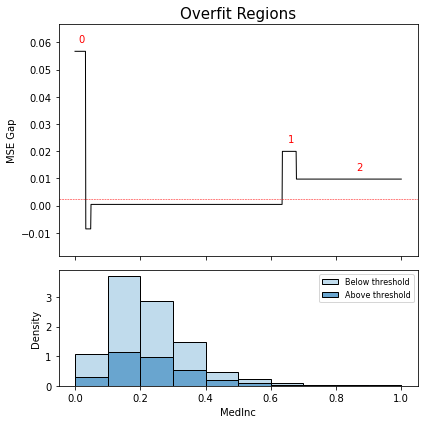

In [ ]:
exp.model_diagnose(model='GAMI-Net', show='overfit_plot', slice_features=['MedInc'], 
                   slice_method='tree', threshold=1.2, min_sample=20, figsize=(6, 6))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

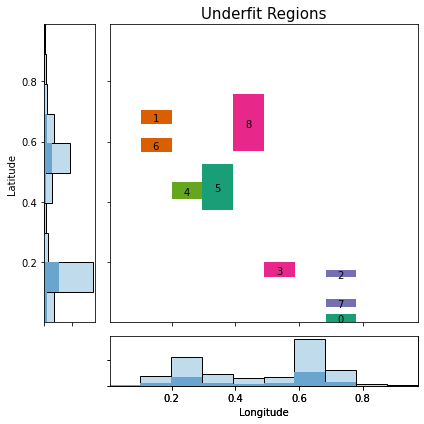

In [ ]:
exp.model_diagnose(model='GAMI-Net', show='underfit_plot', slice_features=['Longitude', 'Latitude'], 
                   slice_method='histogram', threshold=1.2, min_sample=20, figsize=(6, 6))

In [ ]:
exp.model_diagnose(model='GAMI-Net', show='reliability', alpha=0.1, 
                   threshold=1.2, bins=10, target_feature='MedInc')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

In [ ]:
exp.model_diagnose(model='GAMI-Net', show='robustness', perturb_features='All Features',
                   step=0.01, alpha=0.1)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

In [ ]:
exp.model_diagnose(model='GAMI-Net', show='resilience', immu_feature='None', 
                   target_feature='MedInc', alpha=0.1)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

Box(children=(HBox(children=(Box(children=(VBox(children=(Output(), Output())),), layout=Layout(width='36%')),…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

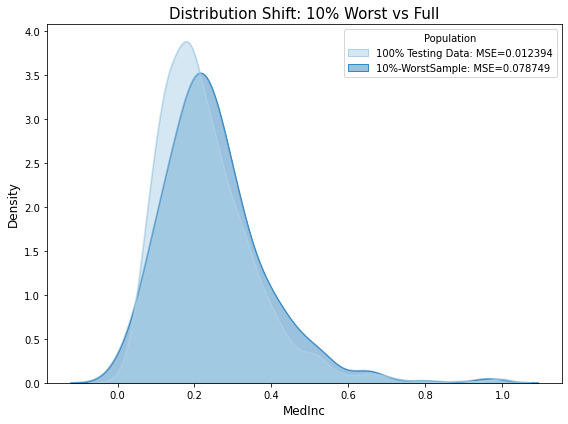

In [ ]:
exp.model_diagnose(model='GAMI-Net', show='resilience_shift_density', immu_feature='HouseAge', 
                   target_feature='MedInc', alpha=0.1, figsize=(8,6))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

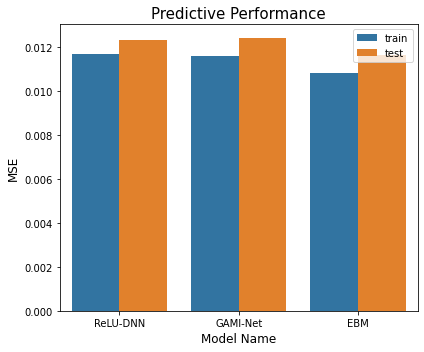

In [ ]:
exp.model_compare(models=['ReLU-DNN', 'GAMI-Net', 'EBM'], show='accuracy_mse', figsize=(6,5))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

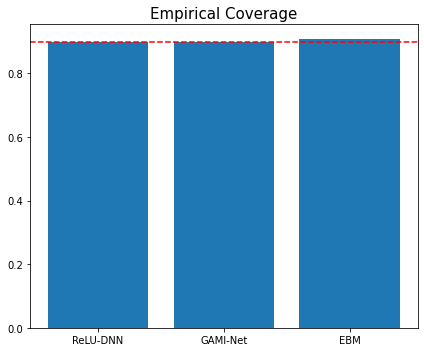

In [ ]:
exp.model_compare(models=['ReLU-DNN', 'GAMI-Net', 'EBM'], show='reliability_coverage', figsize=(6,5))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

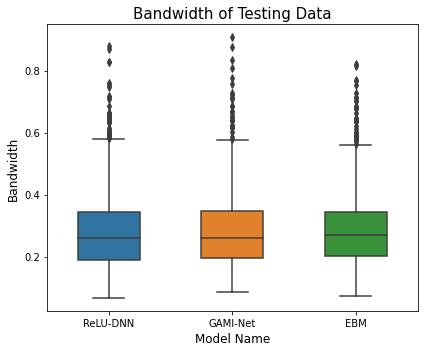

In [ ]:
exp.model_compare(models=['ReLU-DNN', 'GAMI-Net', 'EBM'], show='reliability_bandwidth', figsize=(6,5))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

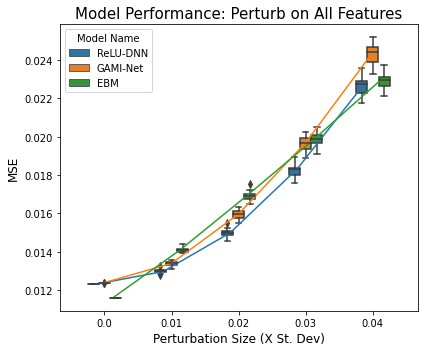

In [ ]:
exp.model_compare(models=['ReLU-DNN', 'GAMI-Net', 'EBM'], show='robustness_perf', figsize=(6,5))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

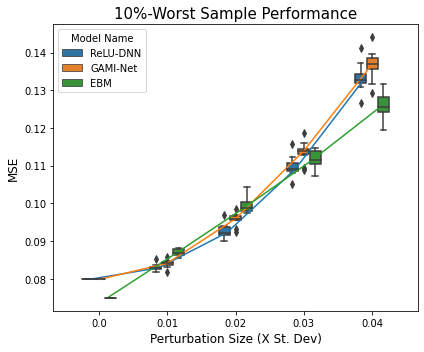

In [ ]:
exp.model_compare(models=['ReLU-DNN', 'GAMI-Net', 'EBM'], show='robustness_perf_worst', figsize=(6,5))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

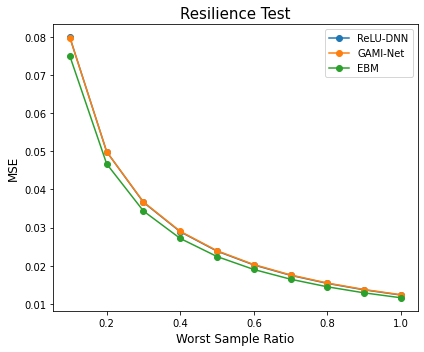

In [ ]:
exp.model_compare(models=['ReLU-DNN','GAMI-Net', 'EBM'], show='resilience_perf', 
                  immu_feature='None', figsize=(6,5))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

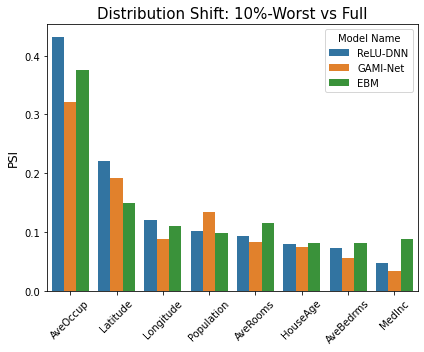

In [ ]:
exp.model_compare(models=['ReLU-DNN', 'GAMI-Net', 'EBM'], show='resilience_psi', 
                  immu_feature='None', figsize=(6,5))

#Stage 5. Register an arbitrary model ... 

In [ ]:
from lightgbm import LGBMRegressor

clf = LGBMRegressor(max_depth=7, n_estimators=500)
pipeline = exp.make_pipeline(model=clf, name='LightGBM')
pipeline.fit()
exp.register(pipeline=pipeline)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value="<p class='notification info'>Register LightGBM Done</p>")

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

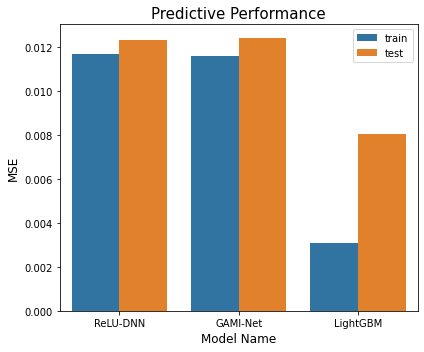

In [ ]:
exp.model_compare(models=['ReLU-DNN', 'GAMI-Net', 'LightGBM'], show='accuracy_mse', figsize=(6,5))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

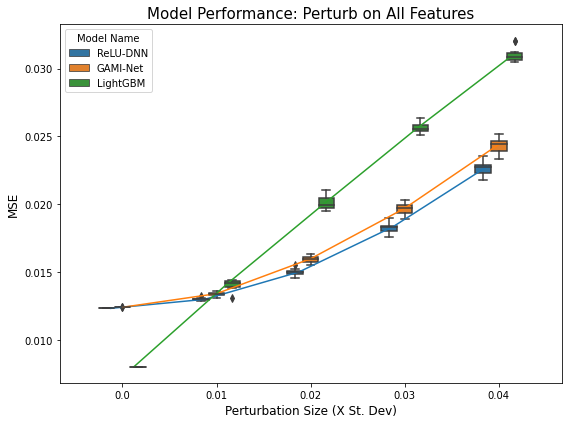

In [ ]:
exp.model_compare(models=['ReLU-DNN', 'GAMI-Net', 'LightGBM'], show='robustness_perf', 
                  perturb_features='All Features', step=0.01, figsize=(8,6))